In [1]:
import librosa
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio 

samplerate = 16000
block_size = 257
n_mels = 256
n_fft = 1024
signal_length = 65536

/home/rein/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(f, sampling_rate, block_size, signal_length, oneshot, **kwargs):
    s, sr = librosa.load(f, sr=sampling_rate)
    N = (signal_length - len(s) % signal_length) % signal_length
    s = np.pad(s, (0, N))

    if oneshot:
        s = s[..., :signal_length]
        
    s = s.reshape(-1, signal_length)

    melspecs = librosa.feature.melspectrogram(y=s, n_fft = n_fft, hop_length = block_size, sr=samplerate, n_mels=n_mels,fmin = 20, fmax = 8000)
    return s, melspecs

In [3]:
path = '/home/rein/Downloads/development-dataset/Footstep/001.wav'

audio,_ = librosa.load(path, sr=samplerate)
Audio(audio, rate=samplerate)

0.0 -80.0 -45.553104
1.0 -0.0 0.5694138


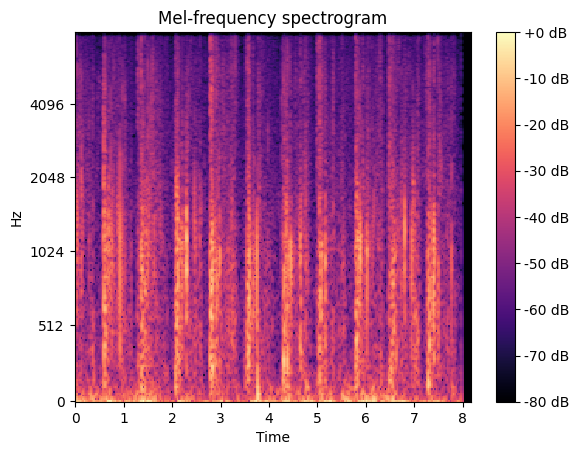

In [4]:
signal, spec = preprocess(path, samplerate, block_size, 65536, oneshot=True)
S_dB = librosa.power_to_db(spec.squeeze(), ref=np.max)
print(S_dB.max(), S_dB.min(), S_dB.mean())

fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=samplerate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
spec = S_dB / -80.0
print(spec.max(), spec.min(), spec.mean())
spec = spec * -80.0
spec = librosa.db_to_power(spec)

In [5]:
audio = librosa.feature.inverse.mel_to_audio(spec, sr=samplerate, n_fft=n_fft, hop_length=block_size)
audio = np.asarray(audio.squeeze())
print(audio.shape)
Audio(audio, rate=samplerate)

(65535,)


In [6]:
max_value = -80.0
def normalize(specs):
    #max_value = specs.min()
    normalized_spec = specs / max_value
    return normalized_spec

def denormalize(log_spec):
    denorm_spec = log_spec * max_value
    return denorm_spec

a = np.load('preprocessed/melspecs.npy')
a = a.squeeze()
print(a.max(), a.min(), a.mean(), a.shape)
b = normalize(a)
print(b.max(), b.min(), b.mean())
c = denormalize(b)
print(c.max(), c.min(), c.mean())

1.0 -1.0 -0.20626327 (4850, 400, 64)
0.0125 -0.0125 0.0025783086
1.0 -1.0 -0.20626327


In [7]:
audio = librosa.feature.inverse.mel_to_audio(spec, sr=samplerate, n_fft=n_fft, hop_length=block_size)
audio = np.asarray(audio.squeeze())
print(audio.shape)
Audio(audio, rate=samplerate)

(65535,)


In [28]:
from preprocess import mel_spectrogram, MAX_WAV_VALUE
from hifigan.hifigan import Vocoder
samplerate = 16000
hop_size = 160
win_size = 1024
num_freq = 1025
n_mels = 64
n_fft = 1024

device = torch.device('cuda:0')
s, _ = librosa.load(path, sr=samplerate)
melspec = mel_spectrogram(s, n_fft=n_fft, num_mels=n_mels, sampling_rate=samplerate, hop_size=hop_size, win_size=win_size, fmin=0, fmax=8000, device=device)
melspec = melspec.cpu().numpy()
audio = librosa.feature.inverse.mel_to_audio(melspec, sr=samplerate, n_fft=n_fft, hop_length=hop_size,n_iter=32)
audio = np.asarray(audio.squeeze()).astype('int16')
audio = audio*MAX_WAV_VALUE
print(audio.shape)
Audio(audio, rate=samplerate)

(63840,)


In [9]:
import utils
import json
from hifigan.__init__ import AttrDict
h = None
config_file = './hifigan/config.json'
with open(config_file) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)
gen_audio = utils.inference(melspec, MAX_WAV_VALUE, Vocoder, h, device)
Audio(gen_audio, rate=samplerate)